In [1]:
import os
import sys
import cv2
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import math
from scipy.stats import gaussian_kde
from matplotlib.ticker import FormatStrFormatter

In [2]:
path_images = 'conv2d_output_inv_greeble_new_params'
# path_images = 'conv2d_output_random_AT'
# path_images = 'conv2d-old_params_base_greebles'
image_filenames = os.listdir(path_images)
image_filenames

['input_init_conv_Conv2D_00.png',
 'input_init_conv_Conv2D_01.png',
 'input_init_conv_Conv2D_02.png',
 'input_init_conv_Conv2D_03.png',
 'input_init_conv_Conv2D_04.png',
 'input_init_conv_Conv2D_05.png',
 'input_init_conv_Conv2D_06.png',
 'input_init_conv_Conv2D_07.png',
 'input_init_conv_Conv2D_08.png',
 'input_init_conv_Conv2D_09.png',
 'input_init_conv_Conv2D_10.png',
 'input_init_conv_Conv2D_11.png',
 'input_init_conv_Conv2D_12.png',
 'input_init_conv_Conv2D_13.png',
 'input_init_conv_Conv2D_14.png',
 'input_init_conv_Conv2D_15.png',
 'unit_1_0_sub1_conv1_Conv2D_00.png',
 'unit_1_0_sub1_conv1_Conv2D_01.png',
 'unit_1_0_sub1_conv1_Conv2D_02.png',
 'unit_1_0_sub1_conv1_Conv2D_03.png',
 'unit_1_0_sub1_conv1_Conv2D_04.png',
 'unit_1_0_sub1_conv1_Conv2D_05.png',
 'unit_1_0_sub1_conv1_Conv2D_06.png',
 'unit_1_0_sub1_conv1_Conv2D_07.png',
 'unit_1_0_sub1_conv1_Conv2D_08.png',
 'unit_1_0_sub1_conv1_Conv2D_09.png',
 'unit_1_0_sub1_conv1_Conv2D_10.png',
 'unit_1_0_sub1_conv1_Conv2D_11.png',


In [3]:
# How much to crop from each side of the image
border = (7, 23, 7, 7) # left, top, right, bottom

original_images = []
for fname in image_filenames:
    img = Image.open(os.path.join(path_images, fname))
    img = ImageOps.crop(img, border)
    img = np.array(img)[...,:3]
    original_images.append(img)
    
original_images = np.array(original_images)
print("n:{}, w:{}, h:{}, c:{}".format(*original_images.shape))

n:889, w:250, h:250, c:3


In [4]:
def rgb2gray(img):
    return np.dot(img[... , :3] , [0.299 , 0.587, 0.114])

# Threshold intensity value
tr_value = 195
# value to set pixels if they are above thresholds
above_t_set = 255
DISPLAY_IMAGES = False
DISPLAY_INFO = False


image_dict = {}
num_errors = 0
for i in range(len(image_filenames)):
    img = original_images[i]
    
    if DISPLAY_INFO:
        print("Img Min:{:.3f}, Img Median:{:.3f}, Img Max: {:.3f}".format(np.min(img), np.median(img), np.max(img)))

    img_gray = rgb2gray(img)
    f = np.fft.fft2(img_gray)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    ret,img_td = cv2.threshold(magnitude_spectrum, tr_value, above_t_set, cv2.THRESH_BINARY)

    if DISPLAY_IMAGES:
        # Display binary image
        fig, ax = plt.subplots(nrows=1, ncols=2)
        fig.set_size_inches((8, 8))

        ax[0].set_title('Image')
        ax[0].imshow(img)
        ax[1].set_title('Binary Image')
        ax[1].imshow(img_td,'gray')
        plt.tight_layout()
        plt.show()

    ############
    # Convert to cv2 format
    img_gray = (img_td*255).astype(np.uint8)
    moments = cv2.moments(img_gray)

    # http://raphael.candelier.fr/?blog=Image%20Moments
    m00 = moments['m00']
    m10 = moments['m10']
    m01 = moments['m01']
    m11 = moments['m11']
    m02 = moments['m02']
    m20 = moments['m20']

    try:
        # Barycenter
        xx = m10/m00
        yy = m01/m00

        # Central moments (intermediary step)
        a = m20/m00 - xx**2
        b = 2*(m11/m00 - xx*yy)
        c = m02/m00 - yy**2

        # Orientation (radians)
        theta = 1/2*math.atan(b/(a-c)) + (a<c)*math.pi/2;
        thetaR = theta
        theta = np.rad2deg(theta) % 180 #convert to degrees in range
    except:
        # For when there is no moment
        num_errors +=1
        e = str(sys.exc_info()[0]).split("'")
        if DISPLAY_INFO: print(e[1])
        theta = -1
        thetaR = -1
    
    if DISPLAY_INFO:
        print("Angle:", theta)
    
#     theta_dict = {'theta_d': theta, 'theta_r': thetaR}
    theta_dict = theta
    image_dict[image_filenames[i]] = theta_dict
    
print('Processed {} images total, with {} undecided image angles'.format(i+1,num_errors))

Processed 889 images total, with 43 undecided image angles


In [5]:
display(image_dict)
print(len(image_dict.values()))
clean_dict = {key:val for key, val in image_dict.items() if val != -1}
print(len(clean_dict.values()))
display(clean_dict)
np_values = np.array(list(clean_dict.values()))

{'input_init_conv_Conv2D_00.png': -1,
 'input_init_conv_Conv2D_01.png': 0.0,
 'input_init_conv_Conv2D_02.png': 0.0,
 'input_init_conv_Conv2D_03.png': 0.0,
 'input_init_conv_Conv2D_04.png': 0.0,
 'input_init_conv_Conv2D_05.png': 0.0,
 'input_init_conv_Conv2D_06.png': 0.0,
 'input_init_conv_Conv2D_07.png': 90.0,
 'input_init_conv_Conv2D_08.png': 0.0,
 'input_init_conv_Conv2D_09.png': 0.0,
 'input_init_conv_Conv2D_10.png': 0.0,
 'input_init_conv_Conv2D_11.png': 0.0,
 'input_init_conv_Conv2D_12.png': 0.0,
 'input_init_conv_Conv2D_13.png': -1,
 'input_init_conv_Conv2D_14.png': 0.0,
 'input_init_conv_Conv2D_15.png': 0.0,
 'unit_1_0_sub1_conv1_Conv2D_00.png': 90.0,
 'unit_1_0_sub1_conv1_Conv2D_01.png': -1,
 'unit_1_0_sub1_conv1_Conv2D_02.png': 90.36028748762101,
 'unit_1_0_sub1_conv1_Conv2D_03.png': 85.27102864754488,
 'unit_1_0_sub1_conv1_Conv2D_04.png': 0.0,
 'unit_1_0_sub1_conv1_Conv2D_05.png': 161.6294206623473,
 'unit_1_0_sub1_conv1_Conv2D_06.png': 0.05479826677328376,
 'unit_1_0_sub1_co

889
846


{'input_init_conv_Conv2D_01.png': 0.0,
 'input_init_conv_Conv2D_02.png': 0.0,
 'input_init_conv_Conv2D_03.png': 0.0,
 'input_init_conv_Conv2D_04.png': 0.0,
 'input_init_conv_Conv2D_05.png': 0.0,
 'input_init_conv_Conv2D_06.png': 0.0,
 'input_init_conv_Conv2D_07.png': 90.0,
 'input_init_conv_Conv2D_08.png': 0.0,
 'input_init_conv_Conv2D_09.png': 0.0,
 'input_init_conv_Conv2D_10.png': 0.0,
 'input_init_conv_Conv2D_11.png': 0.0,
 'input_init_conv_Conv2D_12.png': 0.0,
 'input_init_conv_Conv2D_14.png': 0.0,
 'input_init_conv_Conv2D_15.png': 0.0,
 'unit_1_0_sub1_conv1_Conv2D_00.png': 90.0,
 'unit_1_0_sub1_conv1_Conv2D_02.png': 90.36028748762101,
 'unit_1_0_sub1_conv1_Conv2D_03.png': 85.27102864754488,
 'unit_1_0_sub1_conv1_Conv2D_04.png': 0.0,
 'unit_1_0_sub1_conv1_Conv2D_05.png': 161.6294206623473,
 'unit_1_0_sub1_conv1_Conv2D_06.png': 0.05479826677328376,
 'unit_1_0_sub1_conv1_Conv2D_07.png': 0.0,
 'unit_1_0_sub1_conv1_Conv2D_08.png': 35.93516515678229,
 'unit_1_0_sub1_conv1_Conv2D_09.png'

20
283.0


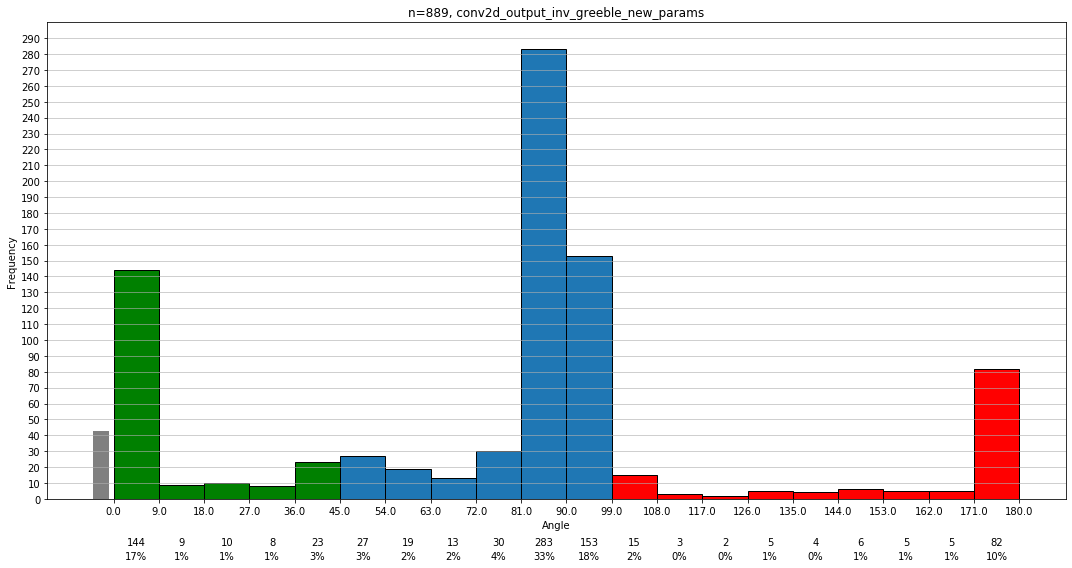

<Figure size 864x576 with 0 Axes>

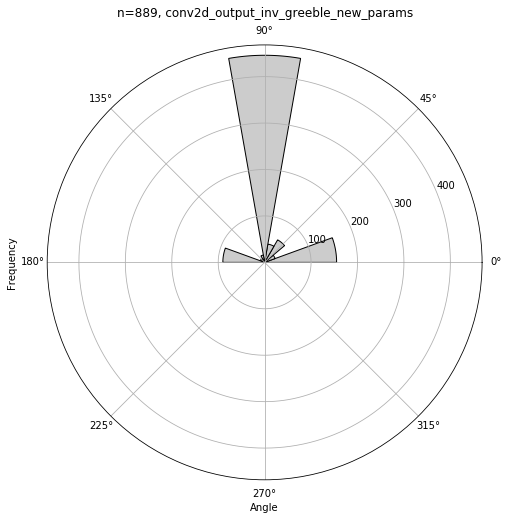

In [6]:
def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

# fig = plt.figure()
fig, ax = plt.subplots()
fig.set_size_inches((15, 8))

counts, bins, patches = plt.hist(image_dict.values(), bins=20, range=(0.0, 180.0),
                               fc='#1f77b4', ec='k')  # FaceColor, EdgeColor

_ = plt.hist(image_dict.values(), bins = 1, range=(-4, -1), color = 'gray', alpha = 1.0)

# Set the ticks to be at the edges of the bins.
ax.set_xticks(bins)
# Set the xaxis's tick labels to be formatted with 1 decimal place...
ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))

# Change the colors of bars at the edges...
twentyfifth, seventyfifth = np.percentile(np_values, [25, 75])
for patch, rightside, leftside in zip(patches, bins[1:], bins[:-1]):
    if rightside < twentyfifth:
        patch.set_facecolor('green')
    elif leftside > seventyfifth:
        patch.set_facecolor('red')

# Label the raw counts and the percentages below the x-axis...
bin_centers = 0.5 * np.diff(bins) + bins[:-1]
for count, x in zip(counts, bin_centers):
    # Label the raw counts
    ax.annotate("{}".format(int(count)), xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -18-20), textcoords='offset points', va='top', ha='center')

    # Label the percentages
    percent = '%0.0f%%' % (100 * float(count) / counts.sum())
    ax.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -32-20), textcoords='offset points', va='top', ha='center')


# Give ourselves some more room at the bottom of the plot
plt.subplots_adjust(bottom=0.15)

print(len(bins) - 1)
print(counts.max())
plt.grid(axis='y', alpha=0.75)
plt.ylim(top=300)
plt.yticks(np.arange(0, 300, 10))
# plt.xticks(np.arange(0, np.max(bins) + bins[1], bins[1]))
plt.xlabel('Angle')
plt.ylabel('Frequency')
plt.title('n={}, {}'.format(i+1, path_images))

plt.tight_layout()
plt.savefig('{}.png'.format(path_images), dpi=300)


## Other plots
fig  = plt.figure()
fig.set_size_inches((12, 8))
x, y = pol2cart(1, (np_values * (math.pi/180)))
###########################
## Hist2D
# h = plt.hist2d(x, y, bins=len(bins)-1, cmap=plt.cm.jet, density=True)
# plt.colorbar()
###########################
## https://matplotlib.org/3.2.1/gallery/pie_and_polar_charts/polar_scatter.html
# N = 150
# r = 2 * np.random.rand(N)
# theta = 2 * np.pi * np.random.rand(N)
# area = 600 * r**2
# colors = theta
# ax = fig.add_subplot(111, projection='polar')
# # c = ax.scatter(theta, r, c=colors, s=area, cmap='hsv', alpha=0.75)
# c = ax.scatter(np_values * (math.pi/180), np.ones(np_values.shape[0]), cmap='hsv', alpha=0.75)
# ax.set_yticklabels([])
###########################
## Density plot https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib
# xy = np.vstack([x,y])
# z = gaussian_kde(xy)(xy)
# plt.scatter(x, y, c=z, s=100, edgecolor='')
###########################
# https://matplotlib.org/3.1.0/gallery/pie_and_polar_charts/polar_bar.html
# N = len(bins)
# # theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
# theta = bins[1:] * (math.pi/180)
# # radii = 10 * np.random.rand(N)
# heights = counts
# # width = np.pi / 4 * np.random.rand(N)
# width = 0.3
# colors = plt.cm.viridis(heights / 10.)
# ax = plt.subplot(111, projection='polar')
# ax.bar(theta, heights, width=width, bottom=0.0, color='b', alpha=0.5, edgecolor='k')
# ax.set_yticklabels([])
###########################
# https://stackoverflow.com/questions/48769599/how-do-i-plot-a-standard-histogram-data-to-a-polar-histogram-using-python-and-py
bin_size = len(bins) - 1
a, b = np.histogram(np_values, bins=np.arange(0, 360+bin_size, bin_size))
centers = np.deg2rad(np.ediff1d(b)//2 + b[:-1])

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='polar')
ax.bar(centers, a, width=np.deg2rad(bin_size), bottom=0.0, color='.8', edgecolor='k')
# ax.set_theta_zero_location("N")
# ax.set_theta_direction(-1)
# ax.set_yticklabels([])
plt.xlabel('Angle')
plt.ylabel('Frequency', labelpad=30)
plt.title('n={}, {}'.format(i+1, path_images))

plt.savefig('polar_{}.png'.format(path_images), dpi=300)

plt.show()